<a href="https://colab.research.google.com/github/ashishmahan/Cricket-Shot-Prediction/blob/main/Updated_Ashish_Kumar_Fanplay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mediapipe

In [5]:
import os
import cv2
from google.colab.patches import cv2_imshow
import mediapipe as mp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d aneesh10/cricket-shot-dataset

100% 644M/645M [00:30<00:00, 22.2MB/s]
100% 645M/645M [00:30<00:00, 22.0MB/s]


In [5]:
import zipfile
zip_ref=zipfile.ZipFile('/content/cricket-shot-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:

def extract_keypoints_from_images(data_folder_path):
    mp_pose = mp.solutions.pose

    keypoints_data = []  # List to store keypoints
    labels = []  # List to store labels

    # Initialize Mediapipe Pose model
    with mp_pose.Pose(static_image_mode=True) as pose:
        for idx, shot_type in enumerate(['drive', 'legglance-flick', 'pullshot', 'sweep']):
            shot_folder_path = os.path.join(data_folder_path, shot_type)
            for image_file in os.listdir(shot_folder_path):
                image_path = os.path.join(shot_folder_path, image_file)

                # Read the image
                image = cv2.imread(image_path)

                # Convert image to RGB (Mediapipe requires RGB format)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Process image to extract keypoints
                results = pose.process(image_rgb)

                # Check if keypoints were detected
                if results.pose_landmarks is not None:
                    # Convert keypoints to numpy array
                    keypoints = np.array([[lm.x, lm.y] for lm in results.pose_landmarks.landmark])

                    # Append keypoints to the list
                    keypoints_data.append(keypoints.flatten())
                    labels.append(idx)  # Assign numerical label to shot type

    return np.array(keypoints_data), np.array(labels)

data_folder_path = "/content/data"
keypoints, labels = extract_keypoints_from_images(data_folder_path)
print("Keypoints shape:", keypoints.shape)
print("Labels shape:", labels.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(keypoints, labels, test_size=0.2, random_state=42)

# Train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Train the XGBoost classifier
clf1 = XGBClassifier()
clf1.fit(X_train, y_train)

# Make predictions on the testing set
y_pred1 = clf1.predict(X_test)

# Evaluate the classifier
print("Classification Report_XGBoost:")
print(classification_report(y_test, y_pred1))

# Predict on the test set
y_pred = clf.predict(X_test)

# Print classification report
print("Classification Report_Random Forest:")
print(classification_report(y_test, y_pred))



Keypoints shape: (3314, 66)
Labels shape: (3314,)
Classification Report_XGBoost:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       191
           1       0.85      0.89      0.87       167
           2       0.89      0.89      0.89       162
           3       0.89      0.89      0.89       143

    accuracy                           0.89       663
   macro avg       0.89      0.89      0.89       663
weighted avg       0.89      0.89      0.89       663

Classification Report_Random Forest:
              precision    recall  f1-score   support

           0       0.90      0.85      0.88       191
           1       0.83      0.81      0.82       167
           2       0.86      0.86      0.86       162
           3       0.83      0.91      0.87       143

    accuracy                           0.86       663
   macro avg       0.86      0.86      0.86       663
weighted avg       0.86      0.86      0.86       663



In [7]:
import joblib

# clf is trained Random Forest classifier
joblib.dump(clf, "clf_Random_Forest.pkl")

# Load the saved model
loaded_model = joblib.load("clf_Random_Forest.pkl")

# Use the loaded model for prediction
predicted_class = loaded_model.predict(keypoints)


In [8]:
import joblib

# clf1 is trained XGBoost classifier
joblib.dump(clf1, "clf_XGBoost.pkl")

# Load the saved model
loaded_model = joblib.load("clf_XGBoost.pkl")

# Use the loaded model for prediction
predicted_class = loaded_model.predict(keypoints)

In [9]:
# Function to extract keypoints from an image using Mediapipe
def extract_keypoints_from_image(image_path1):
    mp_pose = mp.solutions.pose

    # Load the image
    image = cv2.imread(image_path1)

    # Convert image to RGB (Mediapipe requires RGB format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize Mediapipe Pose model
    with mp_pose.Pose(static_image_mode=True) as pose:
        # Process image to extract keypoints
        results = pose.process(image_rgb)

        # Check if keypoints were detected
        if results.pose_landmarks is not None:
            # Convert keypoints to numpy array
            keypoints = np.array([[lm.x, lm.y] for lm in results.pose_landmarks.landmark])
            return keypoints.flatten()
        else:
            print("No pose landmarks detected in the image.")
            return None


Predicted shot type: legglance-flick


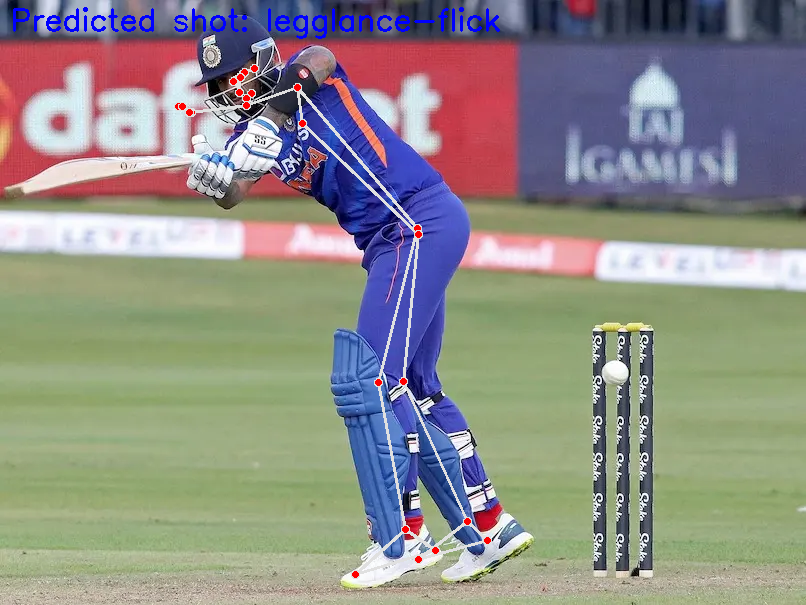

In [30]:

image_path1 = "/content/ww.webp"

shot_names = {0: 'drive', 1: 'legglance-flick', 2: 'pullshot', 3: 'sweep'}
# Extract keypoints from the image
keypoints = extract_keypoints_from_image(image_path1)

if keypoints is not None:
    # Reshape keypoints to match the input format expected by the classifier
    keypoints = keypoints.reshape(1, -1)

    # Predict the shot type using the trained classifier
    predicted_label = clf1.predict(keypoints)
    predicted_shot = shot_names[predicted_label[0]]
    print("Predicted shot type:", predicted_shot)


    # Overlay the keypoints on the image
    image = cv2.imread(image_path1)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    with mp_pose.Pose(static_image_mode=True) as pose:
        image_with_keypoints = image.copy()
        results = pose.process(image_rgb)
        mp_drawing.draw_landmarks(image_with_keypoints, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        cv2.putText(image_with_keypoints, f"Predicted shot: {predicted_shot}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
        cv2_imshow(image_with_keypoints)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
else:
    print("No pose landmarks detected in the image.")
